<a href="https://colab.research.google.com/github/Rafsun-Islam/CSE366/blob/main/Lab02/LabTask/AI_Lab02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import random
import math
import matplotlib.pyplot as plt

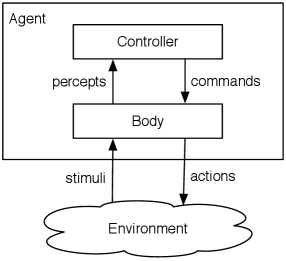

Consider a household trading agent that monitors the price of some commodity, such as toilet paper, by checking for deals online, as well as how much the household has in stock. It must decide whether to order more and how much to order. Assume the percepts are the price and the amount in stock. The command is the number of units the agent decides to order (which is zero if the agent does not order any). A percept trace specifies for each time point (e.g., each day) the price at that time and the amount in stock at that time.

Utilities

In [32]:
def argmaxall(gen):
    """gen is a generator of (element,value) pairs, where value is a real.
    argmaxall returns a list of all of the elements with maximal value.
    """
    maxv = -math.inf       # negative infinity
    maxvals = []      # list of maximal elements
    for (e,v) in gen:
        if v>maxv:
            maxvals,maxv = [e], v
        elif v==maxv:
            maxvals.append(e)
    return maxvals

In [33]:
def argmaxe(gen):
    """gen is a generator of (element,value) pairs, where value is a real.
    argmaxe returns an element with maximal value.
    If there are multiple elements with the max value, one is returned at random.
    """
    return random.choice(argmaxall(gen))

In [34]:
def argmax(lst):
    """returns maximum index in a list"""
    return argmaxe(enumerate(lst))

In [35]:
def argmaxd(dct):
   """returns the arg max of a dictionary dct"""
   return argmaxe(dct.items())

In [36]:
def flip(prob):
    """return true with probability prob"""
    return random.random() < prob

In [37]:
def select_from_dist(item_prob_dist):
  #{6:0.1, 5:0.1, 4:0.1, 3:0.3, 2:0.2, 1:0.2}
    """ returns a value from a distribution.
    item_prob_dist is an item:probability dictionary, where the
        probabilities sum to 1.
    returns an item chosen in proportion to its probability
    """
    ranreal = random.random()
    for (it,prob) in item_prob_dist.items():
        if ranreal < prob:
            return it
        else:
            ranreal -= prob
    raise RuntimeError(f"{item_prob_dist} is not a probability distribution")

Display Class

In [38]:
class Displayable(object):
    """Class that uses 'display'.
    The amount of detail is controlled by max_display_level
    """
    max_display_level = 1   # can be overridden in subclasses or instances

    def display(self,level,*args,**nargs):
        """print the arguments if level is less than or equal to the
        current max_display_level.
        level is an integer.
        the other arguments are whatever arguments print can take.
        """

        if level <= self.max_display_level:
            print(*args, **nargs)  ##if error you are using Python2 not Python3



In [39]:
class Plot_history(object):
    """Set up the plot for history of price and number in stock"""
    def __init__(self, ag, env):
        self.ag = ag
        self.env = env
        plt.ion()
        plt.xlabel("Time")
        plt.ylabel("Value")


    def plot_env_hist(self):
        """plot history of price and instock"""
        num = len(env.stock_history)
        plt.plot(range(num),env.price_history,label="Price")
        plt.plot(range(num),env.stock_history,label="In stock")
        plt.legend()
        #plt.draw()

    def plot_agent_hist(self):
        """plot history of buying"""
        num = len(ag.buy_history)
        plt.bar(range(1,num+1), ag.buy_history, label="Bought")
        plt.legend()
        #plt.draw()

Agent Conntroller

In [40]:
#from display import Displayable

class Agent(Displayable):

    def initial_action(self, percept):
        """return the initial action."""
        return self.select_action(percept)   # same as select_action

    def select_action(self, percept):
        """return the next action (and update internal state) given percept
        percept is variable:value dictionary
        """
        raise NotImplementedError("go")   # abstract method

Environment

In [41]:
class Environment(Displayable):
    def initial_percept(self):
        """returns the initial percept for the agent"""
        raise NotImplementedError("initial_percept")   # abstract method

    def do(self, action):
        """does the action in the environment
        returns the next percept """
        raise NotImplementedError("Environment.do")   # abstract method

Simulate

In [42]:
class Simulate(Displayable):
    """simulate the interaction between the agent and the environment
    for n time steps.
    Returns a pair of the agent state and the environment state.
    """
    def __init__(self,agent, environment):
        self.agent = agent
        self.env = environment
        self.percept = self.env.initial_percept()
        self.percept_history = [self.percept]
        self.action_history = []

    def go(self, n):
        for i in range(n):
            action = self.agent.select_action(self.percept)
            print(f"i={i} action={action}")

            self.percept = self.env.do(action,i)
            print(f"      percept={self.percept}")




TP Env

In [43]:
class TP_env(Environment):
    price_delta = [0, 0, 0, 21, 0, 20, 0, -64, 0, 0, 23, 0, 0, 0, -35,
        0, 76, 0, -41, 0, 0, 0, 21, 0, 5, 0, 5, 0, 0, 0, 5, 0, -15, 0, 5,
       0, 5, 0, -115, 0, 115, 0, 5, 0, -15, 0, 5, 0, 5, 0, 0, 0, 5, 0,
       -59, 0, 44, 0, 5, 0, 5, 0, 0, 0, 5, 0, -65, 50, 0, 5, 0, 5, 0, 0,
       0, 5, 0]
    sd = 5  # noise standard deviation

    def __init__(self):
        """paper buying agent"""
        self.time=0
        self.stock=20
        self.stock_history = []  # memory of the stock history
        self.price_history = []  # memory of the price history

    def initial_percept(self):
        """return initial percept"""
        self.stock_history.append(self.stock)
        self.price = round(234+self.sd*random.gauss(0,1))
        self.price_history.append(self.price)
        #print(f"Initial price: {self.price} ,instock: {self.stock}")
        return {'price': self.price,
                'instock': self.stock}

    def do(self, action, time_unit):
        """does action (buy) and returns percept consisting of price and instock"""
        used = select_from_dist({6:0.1, 5:0.1, 4:0.1, 3:0.3, 2:0.2, 1:0.2})
        print(f"i={time_unit} used={used}")
        # used = select_from_dist({7:0.1, 6:0.2, 5:0.2, 4:0.3, 3:0.1, 2:0.1}) # uses more paper
        bought = action['buy']
        self.stock = self.stock+bought-used
        self.stock_history.append(self.stock)
        self.time += 1
        self.price =  round(self.price
                        + self.price_delta[self.time%len(self.price_delta)] # repeating pattern
                        + self.sd*random.gauss(0,1)) # plus randomness
        self.price_history.append(self.price)
        return {'price': self.price,
                'instock': self.stock}

In [44]:
class TP_agent(Agent):
    def __init__(self):
        self.spent = 0
        percept = env.initial_percept()
        self.ave = self.last_price = percept['price']
        self.instock = percept['instock']
        self.buy_history = []

    def select_action(self, percept):
        """return next action to carry out
        """
        self.last_price = percept['price']
        self.ave = self.ave+(self.last_price-self.ave)*0.05
        self.instock = percept['instock']
        if self.last_price < 0.7*self.ave and self.instock < 30:
            tobuy = 15
        elif self.instock < 10:
            tobuy = 5
        else:
            tobuy = 0
        self.spent += tobuy*self.last_price
        self.buy_history.append(tobuy)
        #print(f"agent buy:{tobuy}")
        return {'buy': tobuy}


In [45]:
env = TP_env()
ag = TP_agent()
sim = Simulate(ag,env)
sim.go(10)
ag.spent/env.time

i=0 action={'buy': 0}
i=0 used=4
      percept={'price': 231, 'instock': 16}
i=1 action={'buy': 0}
i=1 used=1
      percept={'price': 236, 'instock': 15}
i=2 action={'buy': 0}
i=2 used=3
      percept={'price': 253, 'instock': 12}
i=3 action={'buy': 0}
i=3 used=3
      percept={'price': 245, 'instock': 9}
i=4 action={'buy': 5}
i=4 used=3
      percept={'price': 269, 'instock': 11}
i=5 action={'buy': 0}
i=5 used=3
      percept={'price': 271, 'instock': 8}
i=6 action={'buy': 5}
i=6 used=1
      percept={'price': 205, 'instock': 12}
i=7 action={'buy': 0}
i=7 used=3
      percept={'price': 194, 'instock': 9}
i=8 action={'buy': 5}
i=8 used=1
      percept={'price': 201, 'instock': 13}
i=9 action={'buy': 0}
i=9 used=1
      percept={'price': 225, 'instock': 12}


355.0

In [46]:
sim.go(100);

i=0 action={'buy': 0}
i=0 used=6
      percept={'price': 227, 'instock': 6}
i=1 action={'buy': 5}
i=1 used=3
      percept={'price': 224, 'instock': 8}
i=2 action={'buy': 5}
i=2 used=2
      percept={'price': 230, 'instock': 11}
i=3 action={'buy': 0}
i=3 used=6
      percept={'price': 198, 'instock': 5}
i=4 action={'buy': 5}
i=4 used=5
      percept={'price': 201, 'instock': 5}
i=5 action={'buy': 5}
i=5 used=3
      percept={'price': 274, 'instock': 7}
i=6 action={'buy': 5}
i=6 used=6
      percept={'price': 275, 'instock': 6}
i=7 action={'buy': 5}
i=7 used=6
      percept={'price': 235, 'instock': 5}
i=8 action={'buy': 5}
i=8 used=5
      percept={'price': 229, 'instock': 5}
i=9 action={'buy': 5}
i=9 used=3
      percept={'price': 237, 'instock': 7}
i=10 action={'buy': 5}
i=10 used=2
      percept={'price': 240, 'instock': 10}
i=11 action={'buy': 0}
i=11 used=3
      percept={'price': 265, 'instock': 7}
i=12 action={'buy': 5}
i=12 used=6
      percept={'price': 262, 'instock': 6}
i=13

i=0 action={'buy': 5}
i=0 used=3
      percept={'price': 327, 'instock': 11}
i=1 action={'buy': 0}
i=1 used=6
      percept={'price': 326, 'instock': 5}
i=2 action={'buy': 5}
i=2 used=3
      percept={'price': 335, 'instock': 7}
i=3 action={'buy': 5}
i=3 used=3
      percept={'price': 337, 'instock': 9}
i=4 action={'buy': 5}
i=4 used=1
      percept={'price': 221, 'instock': 13}
i=5 action={'buy': 0}
i=5 used=5
      percept={'price': 216, 'instock': 8}
i=6 action={'buy': 5}
i=6 used=2
      percept={'price': 332, 'instock': 11}
i=7 action={'buy': 0}
i=7 used=3
      percept={'price': 334, 'instock': 8}
i=8 action={'buy': 5}
i=8 used=2
      percept={'price': 345, 'instock': 11}
i=9 action={'buy': 0}
i=9 used=2
      percept={'price': 350, 'instock': 9}
i=10 action={'buy': 5}
i=10 used=3
      percept={'price': 342, 'instock': 11}
i=11 action={'buy': 0}
i=11 used=2
      percept={'price': 336, 'instock': 9}
i=12 action={'buy': 5}
i=12 used=3
      percept={'price': 345, 'instock': 11}


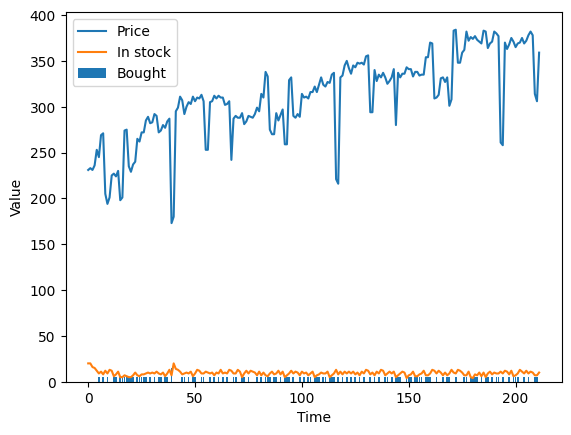

In [47]:
sim.go(100);
print(f"agent spent ${ag.spent/100}")
pl = Plot_history(ag,env); pl.plot_env_hist(); pl.plot_agent_hist()

# **Task 1**
Modify the existing code to fullfill following condtions

1.   If the last_price is less than 70% of the average (ave) and the instock quantity is less than 30, then set tobuy to 15.
2.   Otherwise, if the instock quantity is less than 10, set tobuy to 5.
If none of the above conditions apply, set tobuy to 0.

